In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
import pandas as pd

data =pd.read_csv("drive/My Drive/Colabdrive/tripadvisor_hotel_reviews.csv")
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns


import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

import random as rn

import re

In [ ]:
seed_value = 1337
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

Total examples

In [ ]:
print('Examples in data: {}'.format(len(data)))

Examples in data: 20491


Any null values

In [ ]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

Class Distribution

In [ ]:
class_dist = data['Rating'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [ ]:
ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'Class Distribution')

In [ ]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()

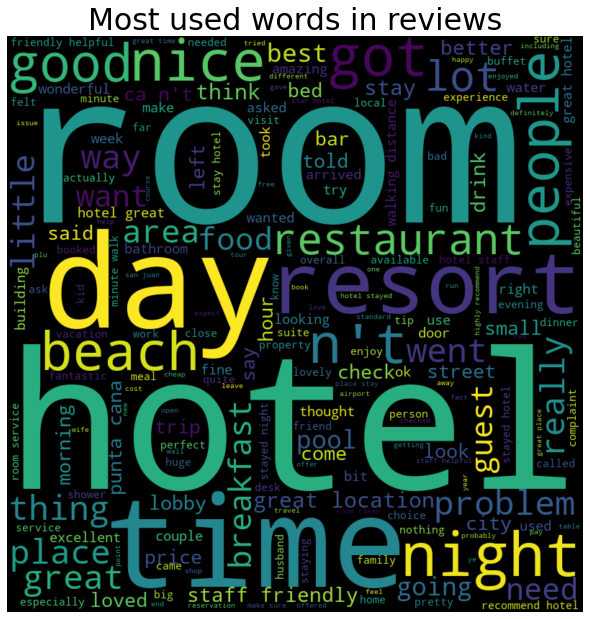

In [ ]:
wordCloud_generator(data['Review'], title="Most used words in reviews")

Data preprocessing

In [ ]:
X = data['Review'].copy()
y = data['Rating'].copy()

Cleaning

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def data_cleaner(review):
    
    # remove digits
    review = re.sub(r'\d+',' ', review)
    
    #removing stop words
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])
    
    #Stemming
    #review = " ".join([ps.stem(w) for w in review])
    
    return review

ps = PorterStemmer() 
stop_words = stopwords.words('english')

X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms * experience hotel monaco seattle g...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

Sentence length distribution

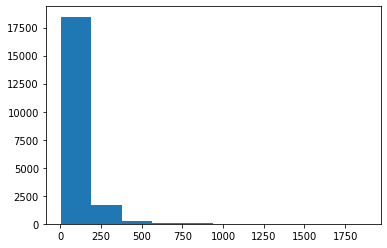

In [ ]:
length_dist = [len(x.split(" ")) for x in X_cleaned]
plt.hist(length_dist)
plt.show()

Tokenizing

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1
exp_sen = 1

print("Vocabulary size: {}".format(vocab_size))
print("max length of sentence: {}".format(max_length))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[exp_sen]))
print("\nAfter tokenizing :\n{}".format(X[exp_sen]))

X = pad_sequences(X, padding='post', maxlen=350)
print("\nAfter padding :\n{}".format(X[exp_sen]))

Vocabulary size: 49536
max length of sentence: 1940

Example:

Sentence:
ok nothing special charge diamond member hilton decided chain shot th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution, send email trip guest survey follow email mail, guess tell concerned guest.the staff ranged indifferent helpful, asked desk good breakfast spots neighborhood hood told hotels, gee best breakfast spots seattle / block away convenient hotel know exist, arrived late

Encoding

In [ ]:
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']
           
y = data['Rating'].copy()
y.replace(encoding, inplace=True)

Split data into train/test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=67, stratify=y
)

Model building and training

In [ ]:
# hyper parameters
EPOCHS = 6
BATCH_SIZE = 64
embedding_dim = 16
units = 76

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    #L.LSTM(units,return_sequences=True),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.5),
    L.Dense(128, activation="relu"),
    L.Dropout(0.5),
    L.Dense(64, activation="relu"),
    L.Dropout(0.5),
    L.Dense(5, activation="softmax")
])


model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 350, 16)           792576    
                                                                 
 bidirectional_2 (Bidirectio  (None, 350, 152)         56544     
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 348, 64)           29248     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 174, 64)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 11136)             0         
                                                                 
 dropout_6 (Dropout)         (None, 11136)            

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/6
189/189 - 32s - loss: 1.2439 - accuracy: 0.4550 - val_loss: 0.9948 - val_accuracy: 0.5376 - 32s/epoch - 168ms/step
Epoch 2/6
189/189 - 26s - loss: 0.9260 - accuracy: 0.5816 - val_loss: 0.8788 - val_accuracy: 0.6025 - 26s/epoch - 138ms/step
Epoch 3/6
189/189 - 24s - loss: 0.7477 - accuracy: 0.6768 - val_loss: 0.9194 - val_accuracy: 0.5989 - 24s/epoch - 128ms/step
Epoch 4/6
189/189 - 24s - loss: 0.5940 - accuracy: 0.7536 - val_loss: 1.0875 - val_accuracy: 0.6068 - 24s/epoch - 127ms/step
Epoch 5/6
189/189 - 24s - loss: 0.4801 - accuracy: 0.8098 - val_loss: 1.2938 - val_accuracy: 0.5850 - 24s/epoch - 126ms/step
Epoch 6/6
189/189 - 24s - loss: 0.3744 - accuracy: 0.8526 - val_loss: 1.5943 - val_accuracy: 0.5704 - 24s/epoch - 127ms/step


In [ ]:
fig = px.line(
    history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()

In [ ]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}
)

fig.show()